# CIFAR-10 Object recognition

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hardcoded_ML as ml

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

% matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Loading the CIFAR-10 dataset
Download the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

In [2]:
folder = "0. Datasets/2. CIFAR-10/"

In [3]:
def unpickle(file):
    '''Function to unpickle a file'''
    import cPickle
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict

def unload_data():    
    for i in range(1,6):
        file_data = unpickle(folder+"data_batch_{0}".format(i))
        data = np.append(data,file_data['data'],axis = 0) if i > 1 else file_data['data']
        labels = np.append(labels,file_data['labels'],axis = 0) if i > 1 else file_data['labels']

    return data,labels

data,labels = unload_data()

In [4]:
print(data.shape)
print(labels.shape)
data_labels = zip(data,labels)

(50000L, 3072L)
(50000L,)


In [5]:
names = unpickle(folder+"batches.meta")['label_names']

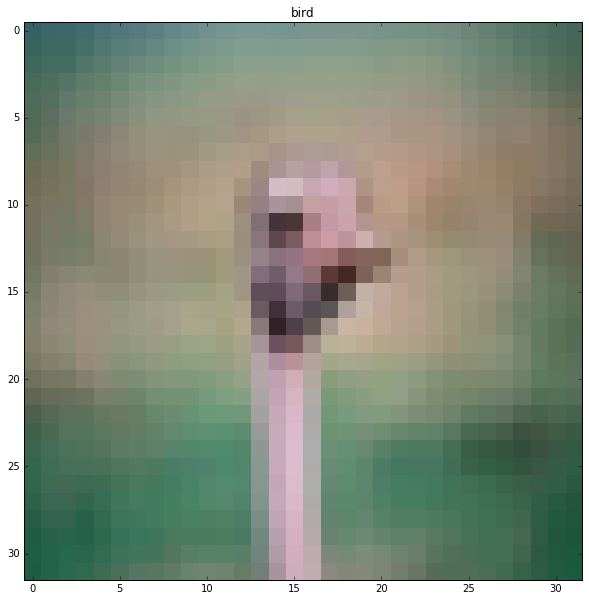

In [6]:
def plot_img(array,title):
    img = array.reshape(3,32,32).transpose(1,2,0)
    plt.title(title)
    plt.imshow(img,interpolation = "nearest")
    plt.show()

img_test = random.choice(data_labels)
plot_img(img_test[0],names[img_test[1]])

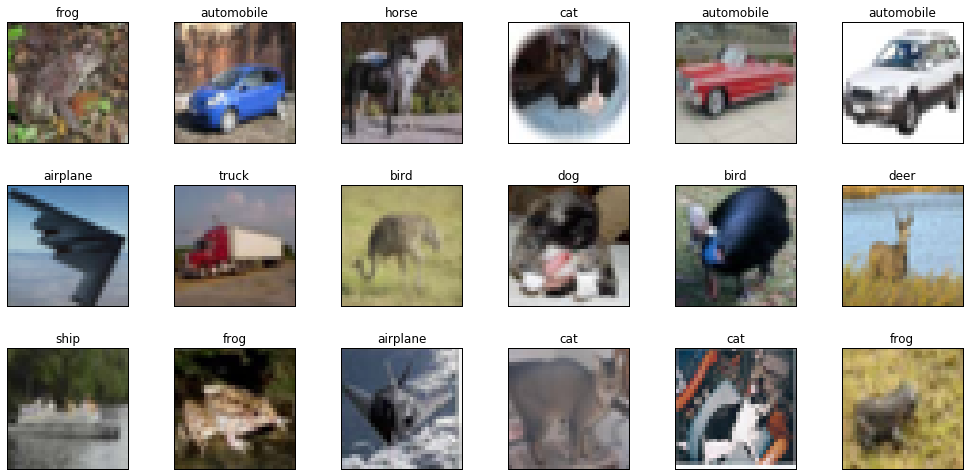

In [7]:
def plot_gallery(images, titles,n_row=3, n_col=6):
    #Helper function to plot a gallery of portraits
    plt.figure(figsize=(2.3 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape(3,32,32).transpose(1,2,0),interpolation="nearest")
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

rdm = np.random.permutation(50000)

plot_gallery(data[rdm], [names[x] for x in labels[rdm]])

#### Creating a test set
Let's create for the following algorithms a test set from 10% of the data, then 5000 examples

In [8]:
from sklearn.cross_validation import train_test_split

X_train,X_test,y_train,y_test = train_test_split(data,labels,test_size = 0.1,random_state = 1)

C:\Users\talvesdacosta\AppData\Local\Continuum\Anaconda3\envs\python2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [9]:
X_train.shape

(45000L, 3072L)

***
## 1. Nearest neighbor hard coded with only numpy
This section is inspired on CS231 course on Visual Recognition. 
To design a Nearest Neighbor classifier, I designed a class which 
- Learns the data when trained
- Tries to predict the class for a new example by computing the distance between it and every sample in the training set, the nearest neigbor is the closest one from which we take the label
- The distance can either be L1,L2 or cosinus (dot product distance)

In [10]:
class NearestNeighbor():
    def __init__(self,distance = "L1"):
        self.distance = distance
    
    def compute_distance(self,first,other):
        if self.distance == "L1":
            return np.sum(np.abs(first-other))
        elif self.distance == "L2":
            return np.sum(np.sqrt((first-other)**2))
        elif self.distance == "cosinus":
            return np.sum(np.dot(first,other))
    
    def train(self,X,y):
        #The nearest neighbor classifier just remembers all the training data
        if X.shape[0] != y.shape[0]:
            raise ValueError("Data and labels don't have the same size")
        self.X_train = X
        self.y_train = y
        
    def predict(self,X,intermediary_steps = 1000,pred_length = None):
        if X.shape[1] != X_train.shape[1]:
            raise ValueError('The test set has not the same shape as the training set')
        if pred_length == None:
            pred_length = len(X)
        y_pred = np.zeros(min(len(X),pred_length))
        
        #ITERATING OVER EVERY EXAMPLE
        for i in range(len(y_pred)):
            if i%intermediary_steps == 0:
                print("Iteration finished on %s samples ..." % i )
            distances = np.apply_along_axis(self.compute_distance,arr = self.X_train,other = X[i,:],axis = 1)
            min_index = np.argmin(distances)
            y_pred[i] = self.y_train[min_index]
            
        return y_pred
            

The test set is too big to be predicted with the Nearest Neighbor algorithm. Because when you predict you compare each picture with the 40k pictures in the training set and then find the minimum, it is extremely slow. 

Let's just take an extract for testing with the first 1000 pictures.

In [12]:
X_test_small,y_test_small = X_test[:1000],y_test[:1000]

In [12]:
model = NearestNeighbor()
model.train(X_train,y_train)

In [13]:
pred_L1 = model.predict(X_test_small,100)

Iteration finished on 0 samples ...
Iteration finished on 100 samples ...
Iteration finished on 200 samples ...
Iteration finished on 300 samples ...
Iteration finished on 400 samples ...
Iteration finished on 500 samples ...
Iteration finished on 600 samples ...
Iteration finished on 700 samples ...
Iteration finished on 800 samples ...
Iteration finished on 900 samples ...


To measure the performance of our algorithms, let's use the accuracy showing the % of correct guesses on the labels

In [14]:
def accuracy(prediction,real):
    accuracy = sum([(prediction[i]==real[i]) for i in range(len(prediction))])/float(len(prediction))
    print('>> Accuracy : {0}%'.format(accuracy))

On the small test set, **the Nearest Neighbor classifier with the L1 distance is XX% accurate** 

In [15]:
accuracy(pred_L1,y_test_small)

>> Accuracy : 0.239%


##### Nearest Neighbor with the L2 distance

In [16]:
model = NearestNeighbor(distance = "L2")
model.train(X_train,y_train)
pred_L2 = model.predict(X_test_small,100)
accuracy(pred_L2,y_test_small)

Iteration finished on 0 samples ...
Iteration finished on 100 samples ...
Iteration finished on 200 samples ...
Iteration finished on 300 samples ...
Iteration finished on 400 samples ...
Iteration finished on 500 samples ...
Iteration finished on 600 samples ...
Iteration finished on 700 samples ...
Iteration finished on 800 samples ...
Iteration finished on 900 samples ...
>> Accuracy : 0.273%


##### Nearest Neighbor with the cosinus distance

In [17]:
model = NearestNeighbor(distance = "cosinus")
model.train(X_train,y_train)
pred_cos = model.predict(X_test_small,100)
accuracy(pred_cos,y_test_small)

Iteration finished on 0 samples ...
Iteration finished on 100 samples ...
Iteration finished on 200 samples ...
Iteration finished on 300 samples ...
Iteration finished on 400 samples ...
Iteration finished on 500 samples ...
Iteration finished on 600 samples ...
Iteration finished on 700 samples ...
Iteration finished on 800 samples ...
Iteration finished on 900 samples ...
>> Accuracy : 0.111%


##### Results
The best results with the NN classifier were shown for the L2 distance. 

Yet, accuracy is only about 25%, which is better than a random pick (10% chance of guessing correctly with 10 classes), but far from human detection or cutting-edge algorithms. 

### Visualizing the prediction
Trying to visualizing why the algorithm was so wrong on the data by showing examples of prediction

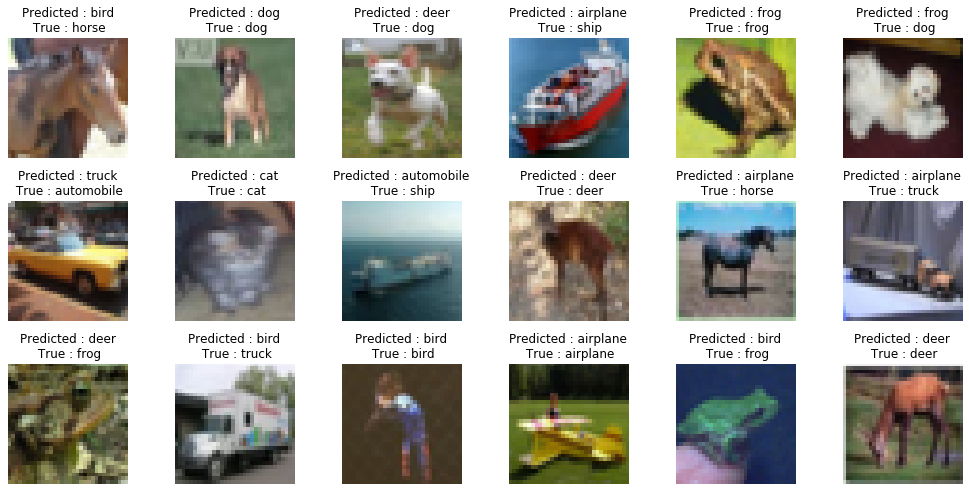

In [18]:
rdm = np.random.permutation(300) #taking again a random permutation on the 300 examples test set
guesses = zip([names[int(x)] for x in pred_L2],[names[x] for x in y_test_small])
titles = np.array(["Predicted : {0}\n True : {1}".format(x[0],x[1]) for x in guesses])
plot_gallery(X_test_small[rdm],titles[rdm])

***
## 2. K-Nearest Neighbors classifier
The first usual improvement on this algorithm is the take not the label of the closest neighbor, but an average on the K first closest neighbors. 

By experience, let's take the 5 closest. 

We need then small improvement on the NN class designed before. 

In [19]:
class KNearestNeighbors():
    def __init__(self,distance = "L1",K = 5):
        self.distance = distance
        self.K = K #add the number of neighbors on which we want the average classification
    
    def compute_distance(self,first,other):
        if self.distance == "L1":
            return np.sum(np.abs(first-other))
        elif self.distance == "L2":
            return np.sum(np.sqrt((first-other)**2))
        elif self.distance == "cosinus":
            return np.sum(np.dot(first,other))
    
    def train(self,X,y):
        #The nearest neighbor classifier just remembers all the training data
        if X.shape[0] != y.shape[0]:
            raise ValueError("Data and labels don't have the same size")
        self.X_train = X
        self.y_train = y
        
    def predict(self,X,intermediary_steps = 1000,pred_length = None):
        if X.shape[1] != X_train.shape[1]:
            raise ValueError('The test set has not the same shape as the training set')
        if pred_length == None:
            pred_length = len(X)
        y_pred = np.zeros(min(len(X),pred_length))
        
        #ITERATING OVER EVERY EXAMPLE
        for i in range(len(y_pred)):
            if i%intermediary_steps == 0:
                print("Iteration finished on %s samples ..." % i )
            distances = np.apply_along_axis(self.compute_distance,arr = self.X_train,other = X[i,:],axis = 1)
            min_indexes = np.argsort(distances)[:self.K] #here we take the K closest example
            counts = np.bincount(self.y_train[min_indexes]) #counting on the iteration of each class in the K guesses
            y_pred[i] = np.argmax(counts) #taking the more frequent class in the K guesses
            
        return y_pred
            

In [20]:
model = KNearestNeighbors(distance = "L2")
model.train(X_train,y_train)
pred_L2 = model.predict(X_test_small,100)
accuracy(pred_L2,y_test_small)

Iteration finished on 0 samples ...
Iteration finished on 100 samples ...
Iteration finished on 200 samples ...
Iteration finished on 300 samples ...
Iteration finished on 400 samples ...
Iteration finished on 500 samples ...
Iteration finished on 600 samples ...
Iteration finished on 700 samples ...
Iteration finished on 800 samples ...
Iteration finished on 900 samples ...
>> Accuracy : 0.221%


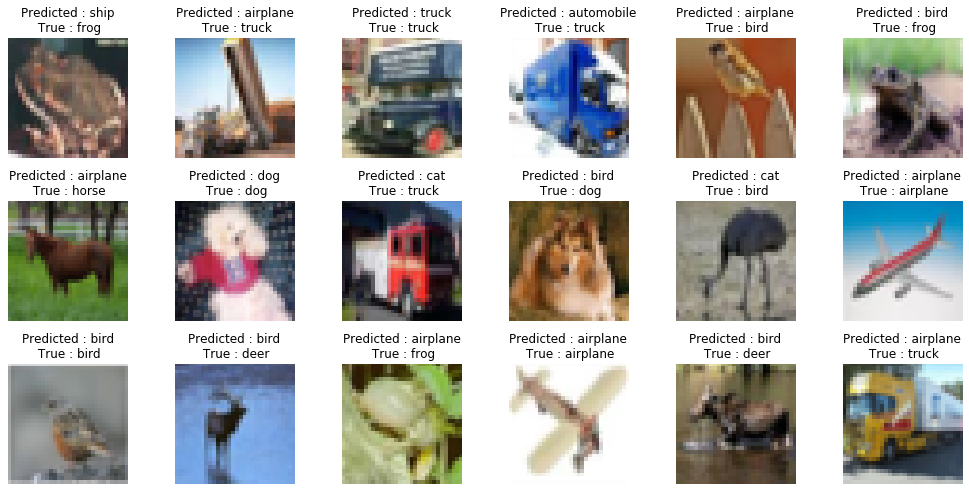

In [21]:
rdm = np.random.permutation(300) #taking again a random permutation on the 300 examples test set
guesses = zip([names[int(x)] for x in pred_L2],[names[x] for x in y_test_small])
titles = np.array(["Predicted : {0}\n True : {1}".format(x[0],x[1]) for x in guesses])
plot_gallery(X_test_small[rdm],titles[rdm])

***
## 3. Logistic Regression - hard coded numpy

In [12]:
LR = ml.LogisticRegression()
LR.train(X_train,y_train,n_steps = 100,optimization="random")
prediction = LR.predict(X_test_small,y_test_small)

>> Processing random search for 100 attempts
... At step 0, the minimum loss is 91.7194
... At step 1, the minimum loss is 91.1042
... At step 6, the minimum loss is 72.247
... At step 8, the minimum loss is 67.8095
... At step 10, the minimum loss is 67.8095
... At step 20, the minimum loss is 67.8095
... At step 30, the minimum loss is 67.8095
... At step 40, the minimum loss is 67.8095
... At step 50, the minimum loss is 67.8095
... At step 60, the minimum loss is 67.8095
... At step 70, the minimum loss is 67.8095
... At step 80, the minimum loss is 67.8095
... At step 90, the minimum loss is 67.8095
>> Updating weights for the best loss found : 67.8095
>> Accuracy of 0.123


In [13]:
LR = ml.LogisticRegression()
LR.train(X_train,y_train,n_steps = 100,optimization="blindfolded_hiker")
prediction = LR.predict(X_test_small,y_test_small)

>> Processing blindfolded hiker optimization for 100 attempts
... At step 0, the minimum loss is 118.108
... At step 10, the minimum loss is 116.802
... At step 20, the minimum loss is 115.996
... At step 30, the minimum loss is 114.722
... At step 40, the minimum loss is 113.692
... At step 60, the minimum loss is 111.051
... At step 80, the minimum loss is 107.975
... At step 90, the minimum loss is 107.085
>> Updating weights for the best loss found : 105.657
>> Accuracy of 0.144


In [14]:
LR = ml.LogisticRegression(learning_rate = 1e-6)
print(LR.learning_rate)
LR.train(X_train,y_train,n_steps = 1000,optimization="mini_batch_gradient_descent")
prediction = LR.predict(X_test_small,y_test_small)

1e-06
>> Processing mini batch gradient descent optimization for 1000 attempts and batch size of 256
... At step 0, the loss is 132.878
... At step 100, the loss is 33.0604
... At step 200, the loss is 31.3399
... At step 300, the loss is 25.7687
... At step 400, the loss is 26.0133
... At step 500, the loss is 24.1689
... At step 600, the loss is 19.9779
... At step 700, the loss is 20.3203
... At step 800, the loss is 19.6392
... At step 900, the loss is 20.7714
>> Updating weights for the last loss found : 20.0451
>> Accuracy of 0.211
